## This project uses time series model SARMAX and finds the best fitting model to forecast weather in delhi for next two years

# Importing Libraries

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [100]:
df=pd.read_csv("/content/testset.csv",parse_dates=['datetime_utc'], index_col='datetime_utc')

# Feature engineering

In [101]:
df.columns

Index([' _conds', ' _dewptm', ' _fog', ' _hail', ' _heatindexm', ' _hum',
       ' _precipm', ' _pressurem', ' _rain', ' _snow', ' _tempm', ' _thunder',
       ' _tornado', ' _vism', ' _wdird', ' _wdire', ' _wgustm', ' _windchillm',
       ' _wspdm'],
      dtype='object')

In [8]:
weatherdf=df[[' _conds',' _hum',' _tempm']]

In [9]:
weatherdf

,_conds,_hum,_tempm
datetime_utc,,,
1996-11-01 11:00:00,Smoke,27.0,30.0
1996-11-01 12:00:00,Smoke,32.0,28.0
1996-11-01 13:00:00,Smoke,44.0,24.0
1996-11-01 14:00:00,Smoke,41.0,24.0
1996-11-01 16:00:00,Smoke,47.0,23.0
...,...,...,...
2017-04-24 06:00:00,Haze,25.0,34.0
2017-04-24 09:00:00,Haze,16.0,38.0
2017-04-24 12:00:00,Haze,14.0,36.0


In [10]:
weatherdf = weatherdf.rename(columns={' _conds': 'condition', ' _hum': 'humidity', ' _tempm': 'temprature'})

In [11]:
weatherdf.dtypes, weatherdf.index.dtype

(condition      object
 humidity      float64
 temprature    float64
 dtype: object,
 dtype('<M8[ns]'))

In [12]:
weatherdf.index = pd.to_datetime(weatherdf.index, errors='coerce')

In [13]:
weatherdf

,condition,humidity,temprature
datetime_utc,,,
1996-11-01 11:00:00,Smoke,27.0,30.0
1996-11-01 12:00:00,Smoke,32.0,28.0
1996-11-01 13:00:00,Smoke,44.0,24.0
1996-11-01 14:00:00,Smoke,41.0,24.0
1996-11-01 16:00:00,Smoke,47.0,23.0
...,...,...,...
2017-04-24 06:00:00,Haze,25.0,34.0
2017-04-24 09:00:00,Haze,16.0,38.0
2017-04-24 12:00:00,Haze,14.0,36.0


# Data Cleaning

In [14]:
weatherdf.isnull().sum()

condition      72
humidity      757
temprature    673
dtype: int64

In [18]:
weatherdf.interpolate(inplace=True)

In [19]:
weatherdf.isnull().sum()

condition     72
humidity       0
temprature     0
dtype: int64

In [20]:
weatherdf.ffill(inplace=True)

In [21]:
weatherdf.isna().sum()

condition     0
humidity      0
temprature    0
dtype: int64

In [22]:
weatherdf.describe()

,humidity,temprature
count,100990.000000,100990.000000
mean,57.957867,25.437821
std,23.809650,8.486879
min,4.000000,1.000000
25%,39.000000,19.000000
50%,59.000000,27.000000
75%,78.000000,32.000000
max,243.000000,90.000000


It is showing maximum temprature as 90 and max humidity as 243 which is non-realistic, so it is an outlier. We need to treat these outliers

In [23]:
weatherdf = weatherdf[weatherdf.temprature <= 55]
weatherdf = weatherdf[weatherdf.humidity <= 100]

In [24]:
weatherdf

,condition,humidity,temprature
datetime_utc,,,
1996-11-01 11:00:00,Smoke,27.0,30.0
1996-11-01 12:00:00,Smoke,32.0,28.0
1996-11-01 13:00:00,Smoke,44.0,24.0
1996-11-01 14:00:00,Smoke,41.0,24.0
1996-11-01 16:00:00,Smoke,47.0,23.0
...,...,...,...
2017-04-24 06:00:00,Haze,25.0,34.0
2017-04-24 09:00:00,Haze,16.0,38.0
2017-04-24 12:00:00,Haze,14.0,36.0


Text(0, 0.5, 'Percent')

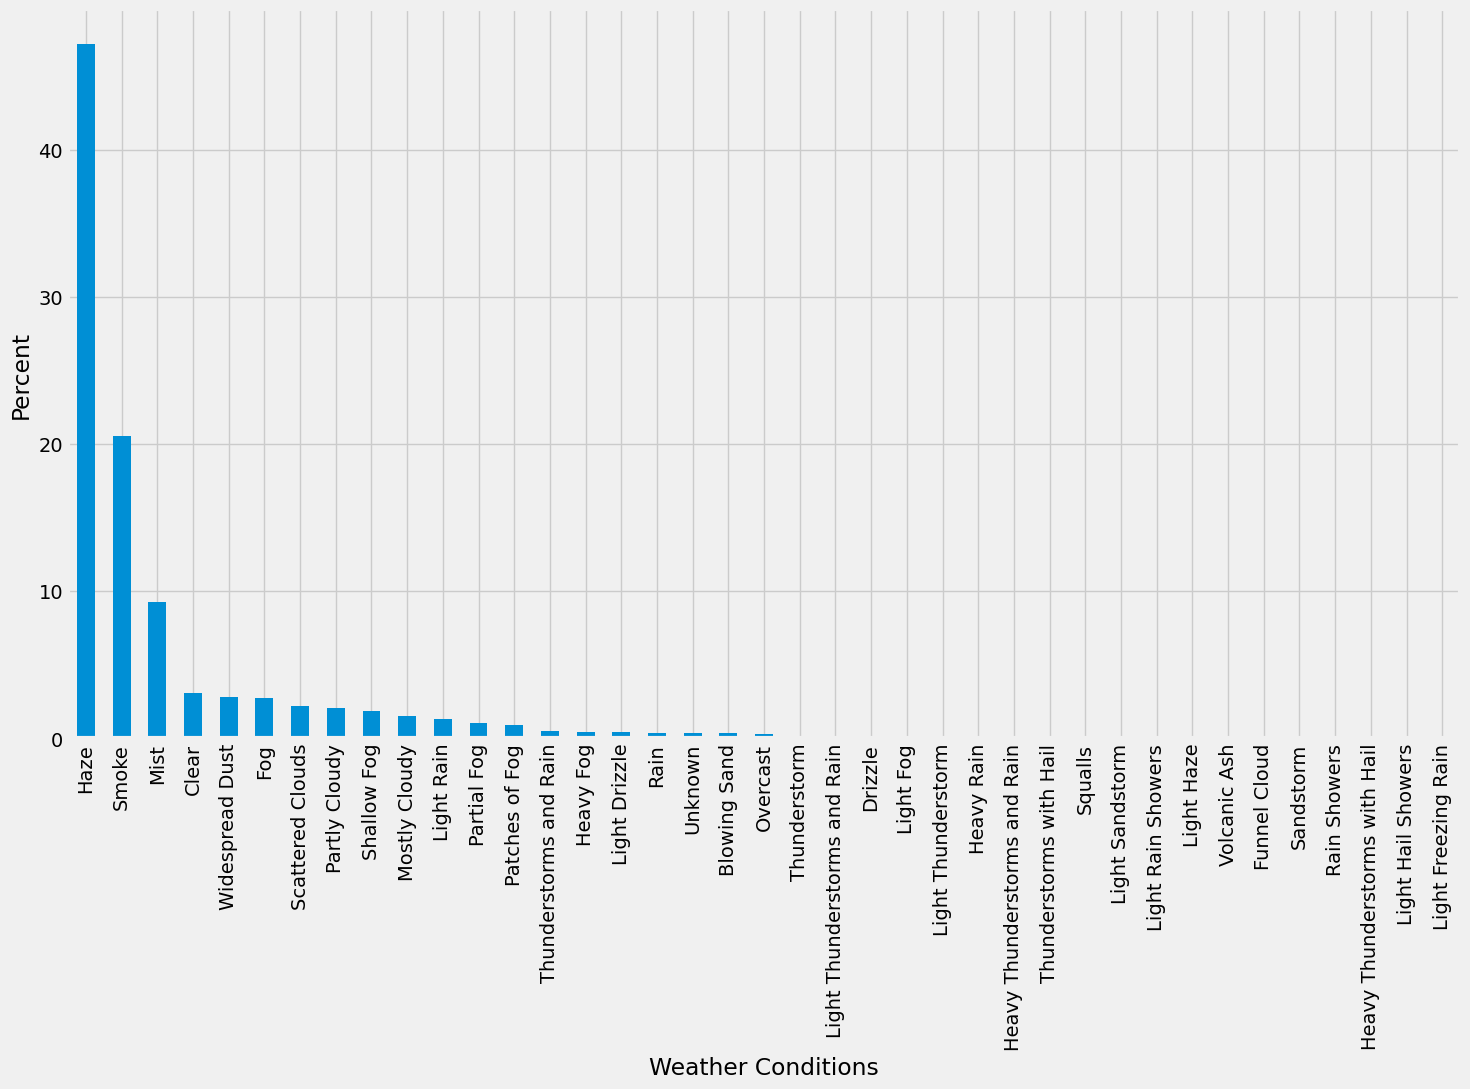

In [102]:
weather_condition = (weatherdf.condition.value_counts()/(weatherdf.condition.value_counts().sum()))*100
weather_condition.plot.bar(figsize=(16,9))
plt.xlabel('Weather Conditions')
plt.ylabel('Percent')

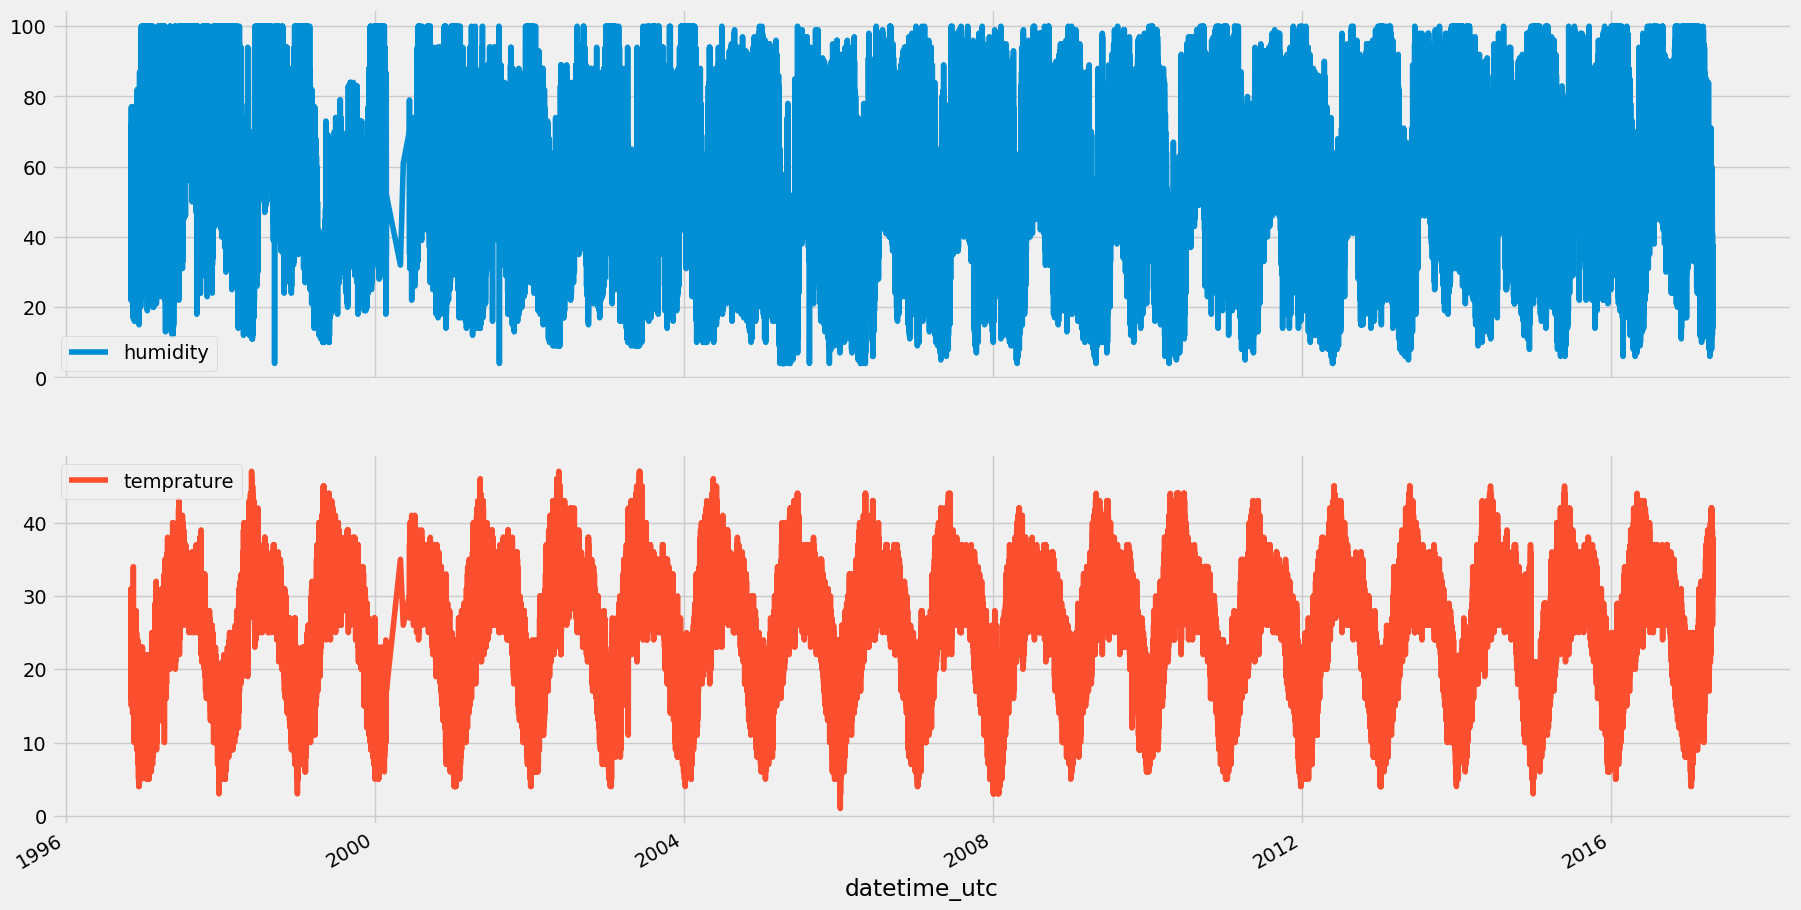

In [103]:
weatherdf.plot(subplots=True, figsize=(20,12))
plt.show()

array([<Axes: xlabel='datetime_utc'>, <Axes: xlabel='datetime_utc'>],
      dtype=object)

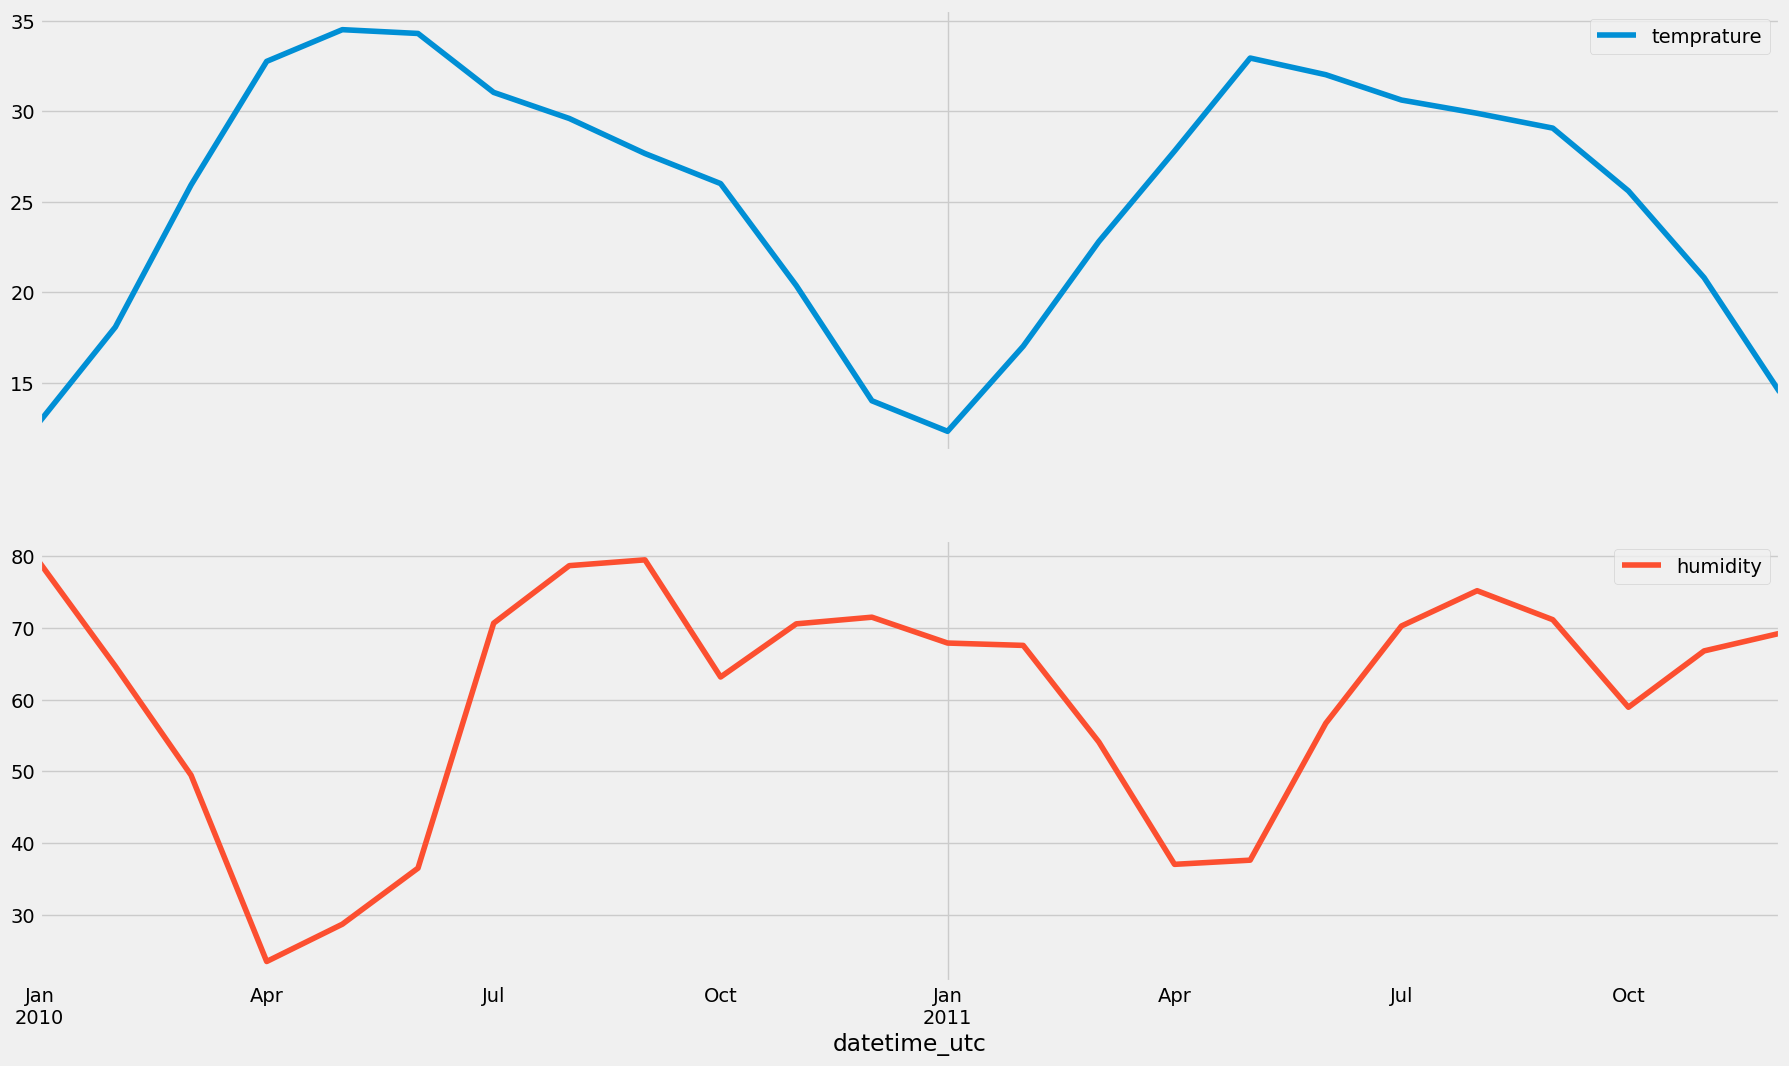

In [104]:
weatherdf[["temprature","humidity"]]["2010":"2011"].resample('M').mean().plot(subplots=True, figsize=(20,12))

In [35]:
train_df = weatherdf.temprature['1997':'2015'].resample('M').mean().interpolate()
test_df = weatherdf.temprature['2016':'2017'].resample('M').mean().interpolate()

In [36]:
train_df

datetime_utc
1997-01-31    12.857798
1997-02-28    15.774597
1997-03-31    21.125458
1997-04-30    26.317434
1997-05-31    29.930728
                ...    
2015-08-31    30.235507
2015-09-30    30.665254
2015-10-31    26.838115
2015-11-30    20.754167
2015-12-31    14.975709
Freq: M, Name: temprature, Length: 228, dtype: float64

In [37]:
test_df

datetime_utc
2016-01-31    15.007752
2016-02-29    19.475827
2016-03-31    25.696391
2016-04-30    32.555556
2016-05-31    34.779297
2016-06-30    34.949451
2016-07-31    30.886503
2016-08-31    31.008575
2016-09-30    31.533454
2016-10-31    28.975776
2016-11-30    23.043228
2016-12-31    17.736682
2017-01-31    15.772370
2017-02-28    18.414062
2017-03-31    23.553459
2017-04-30    30.775120
Freq: M, Name: temprature, dtype: float64

In [38]:
print(train_df.isna().sum())
print(test_df.isna().sum())

0
0


<Axes: xlabel='datetime_utc'>

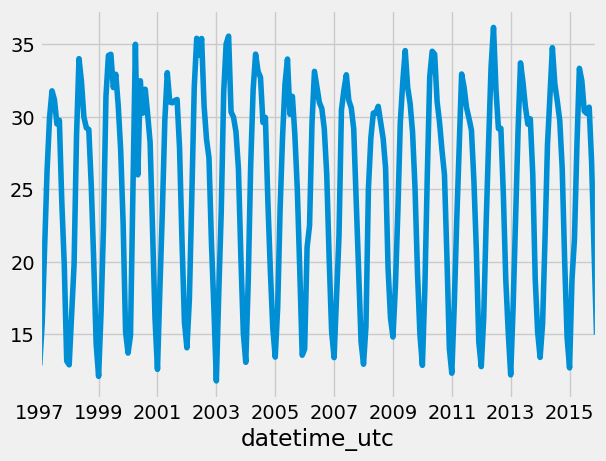

In [105]:
train_df.plot()

<Axes: xlabel='datetime_utc'>

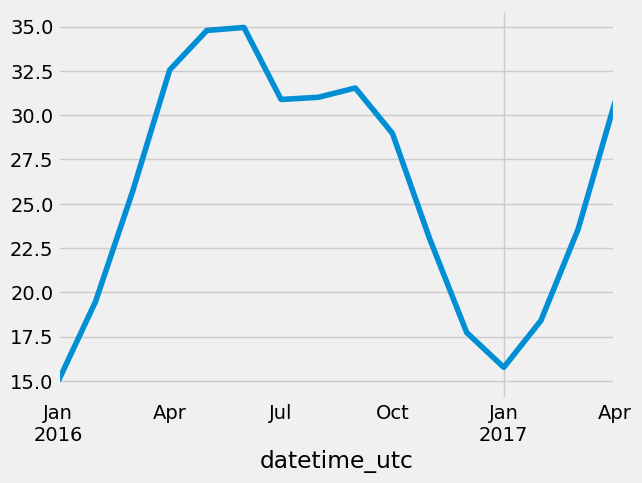

In [106]:
test_df.plot()

# Checking for stationary
* Constant mean
* Constant variance
* An auto co-variance that does not depend on time

In [42]:
adfuller(train_df)

(-2.914303276921358,
 0.04370982418280622,
 11,
 216,
 {'1%': -3.4609922013325267,
  '5%': -2.875015740963014,
  '10%': -2.5739524288408777},
 787.711551274278)

* we can see that it's stationary at 5%

# Check for seasonality

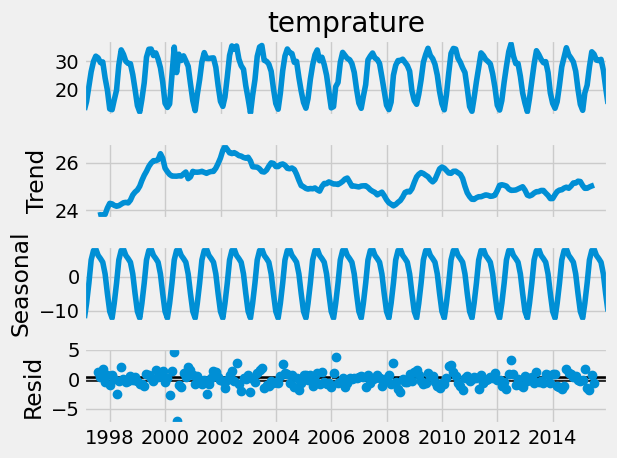

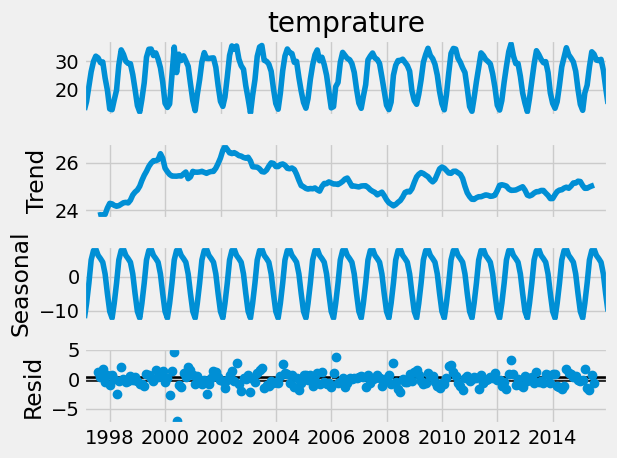

In [107]:
seasonal_decompose(train_df,model="additive").plot()

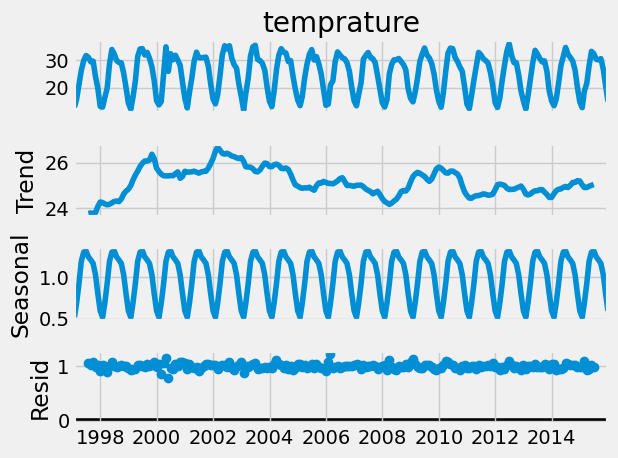

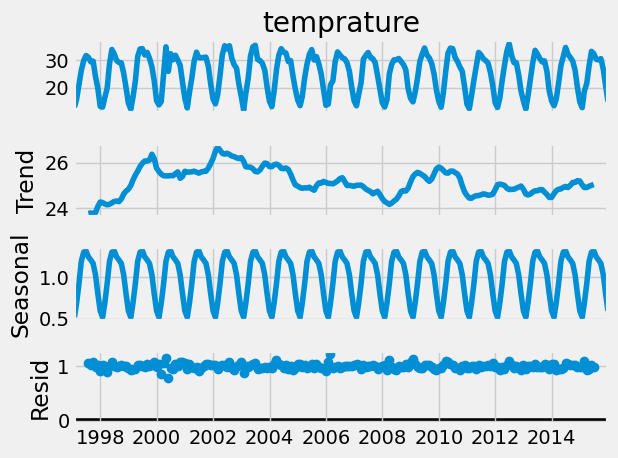

In [108]:
seasonal_decompose(train_df,model="multiplicative").plot()

# Auto-correlation Function and PACF

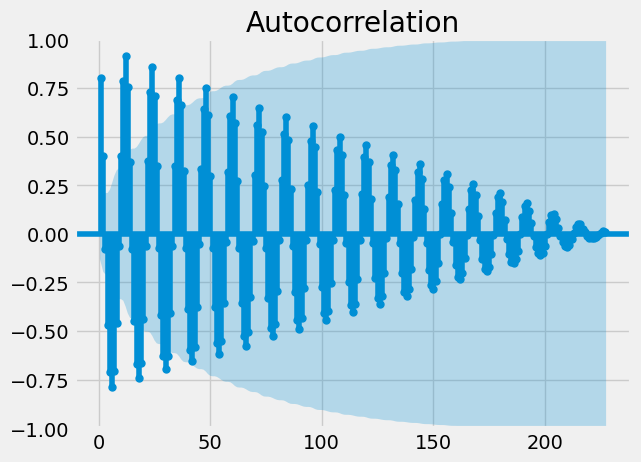

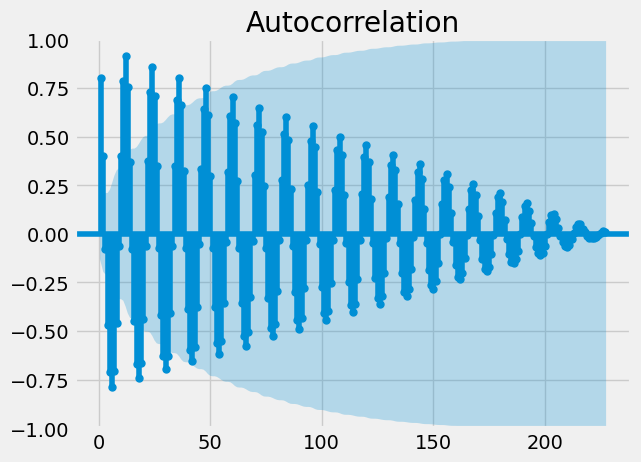

In [109]:
plot_acf(train_df,lags=227,zero=False)

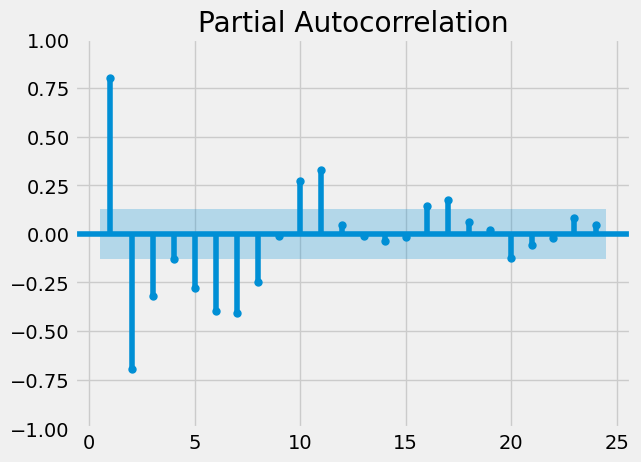

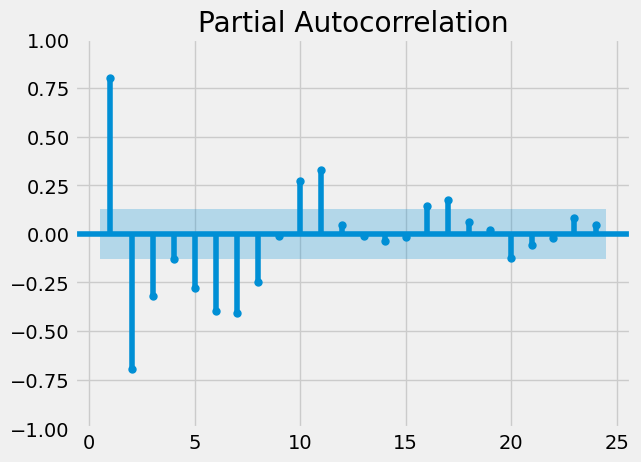

In [110]:
plot_pacf(train_df,zero=False)

In [55]:
xhumidity=weatherdf.humidity['1997':'2015'].resample('M').mean().interpolate()
yhumidity=weatherdf.humidity['2016':'2017'].resample('M').mean().interpolate()

# Auto-ARIMA (SARIMAX)

In [63]:
model_auto = auto_arima(train_df, X = xhumidity.values.reshape(-1,1),
                       m = 12, max_p = 5, d=0, max_q = 5, max_P = 3, max_Q = 3, D=0
                        ,maxiter=50,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=766.895, Time=6.55 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1485.224, Time=0.22 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1143.460, Time=1.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1757.036, Time=0.11 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=864.043, Time=2.61 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=856.688, Time=1.95 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=775.690, Time=7.45 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=773.544, Time=5.50 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=880.073, Time=1.01 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=938.767, Time=7.28 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=815.180, Time=4.10 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=8.61 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=771.184, Time=2.44 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   :

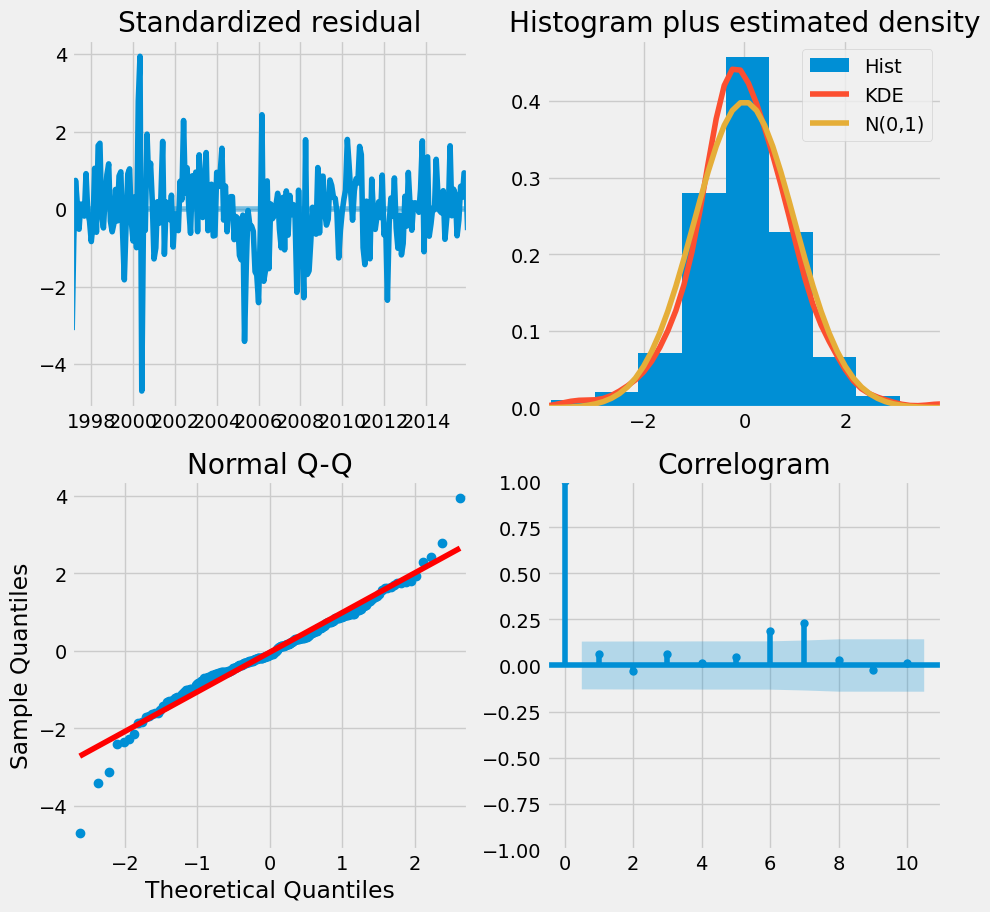

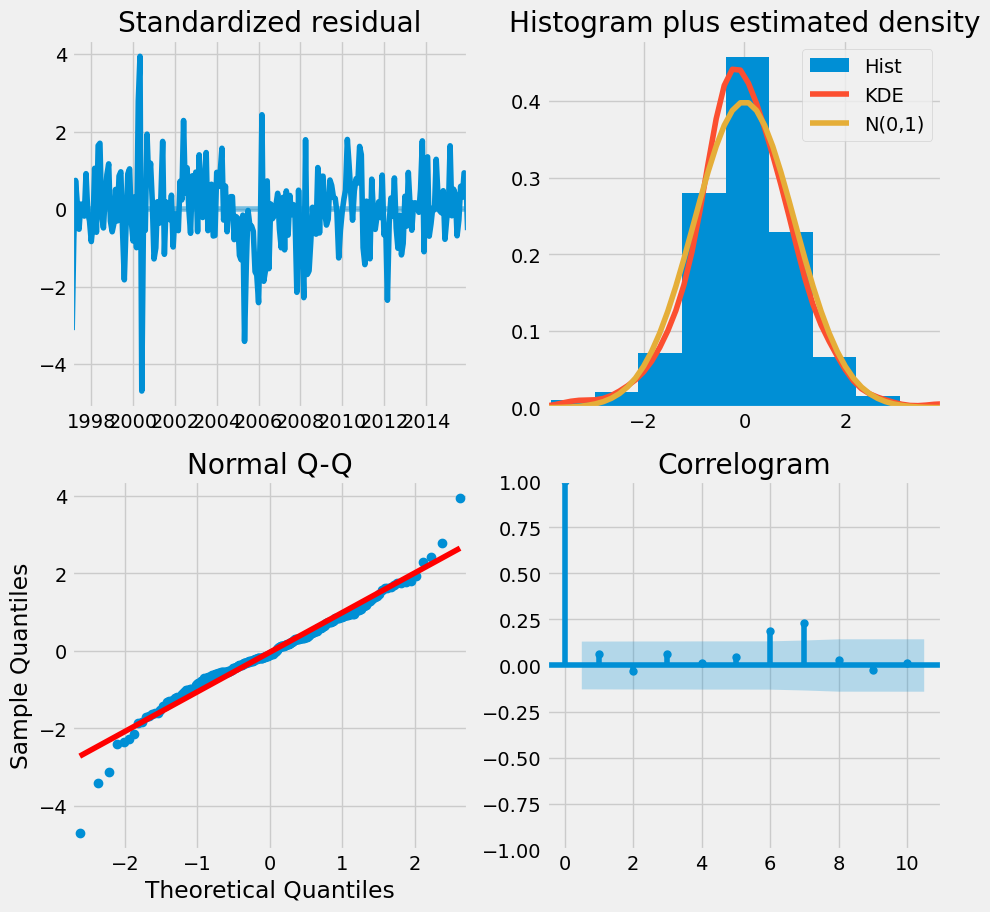

In [111]:
model_auto.plot_diagnostics(figsize=(10,10))

In [121]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(test_df),
                            X = yhumidity.values.reshape(-1,1),
                            index = test_df.index))

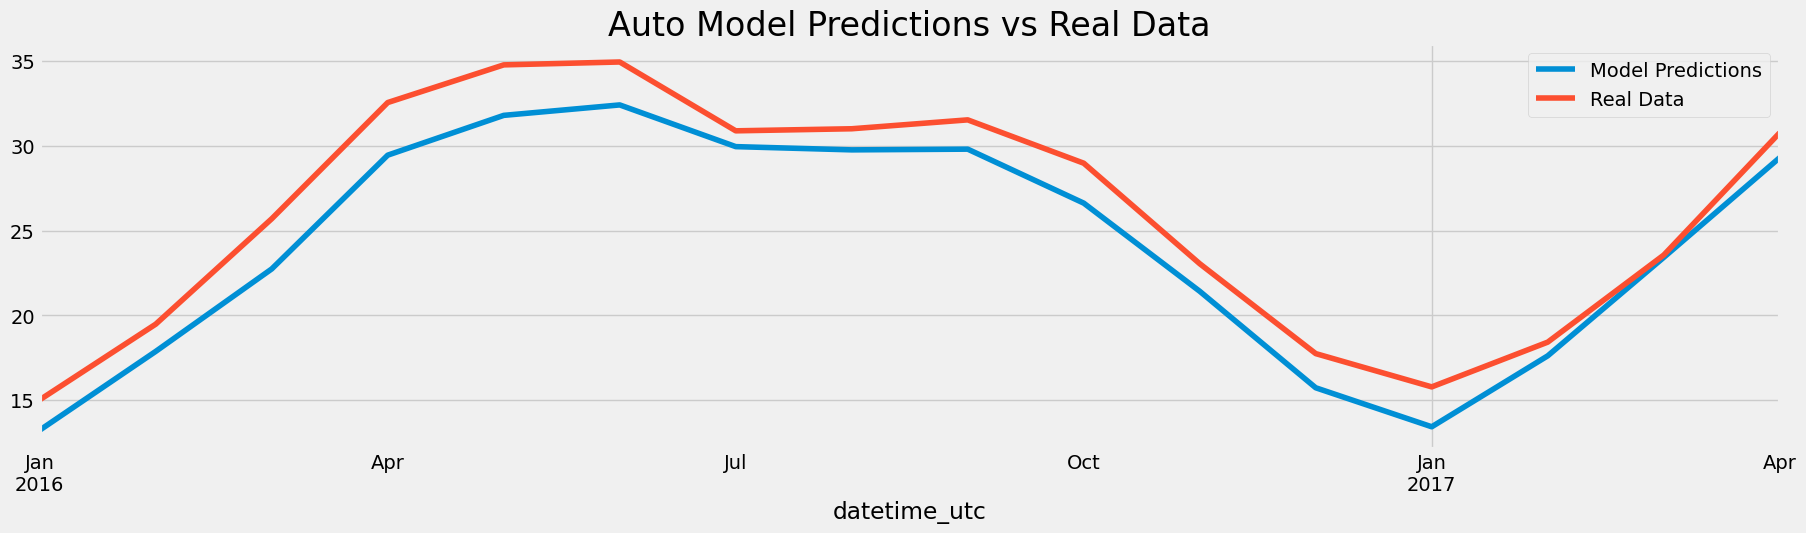

In [112]:
df_auto_pred.plot(figsize = (20,5),label='Model Predictions')
test_df.plot(label='Real Data')
plt.legend(['Model Predictions', 'Real Data'])
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

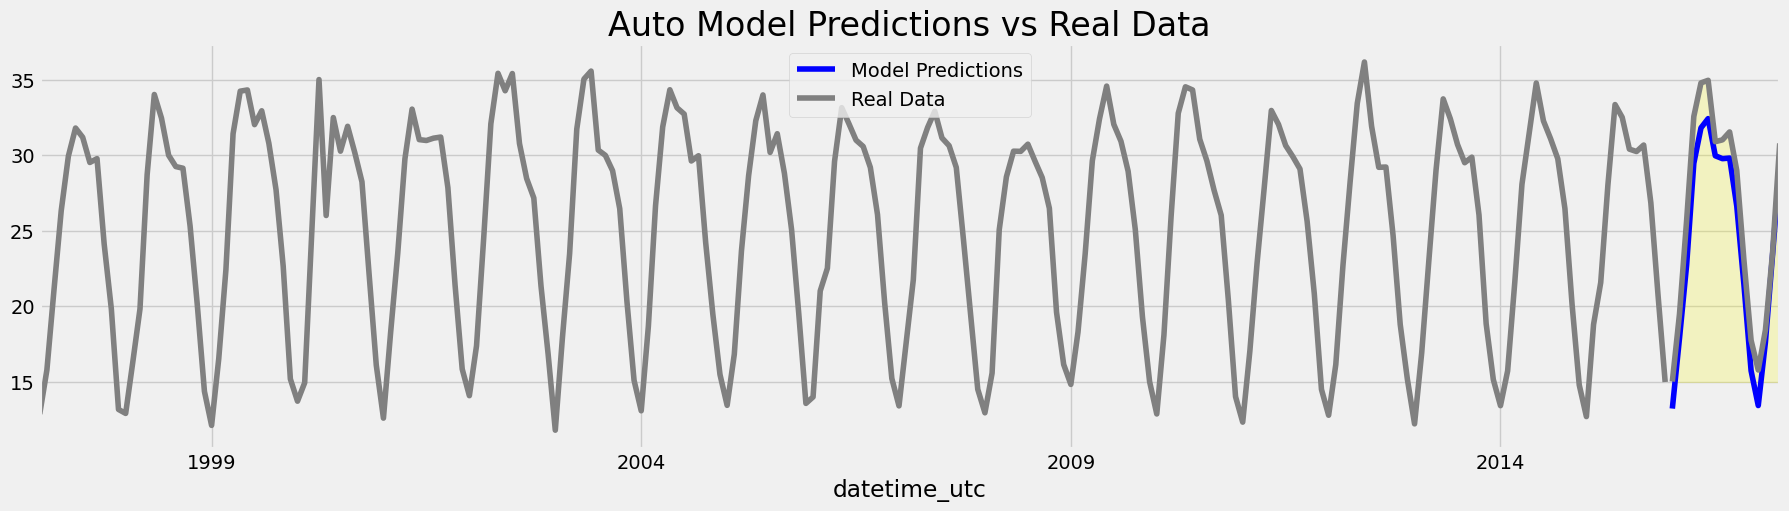

In [113]:
df_auto_pred.plot(figsize = (20,5),label='Model Predictions',color="blue")
test_df.plot(label='Real Data',color="grey")
train_df.plot(label='Real Data',color="grey")
plt.fill_between(test_df.index, test_df.values, train_df.values[-1], color='yellow', alpha=0.2)
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.legend(['Model Predictions','Real Data'])
plt.show()